# Visualizing the space of handwritten digits using masspcf

This notebook serves as an introduction to using the 'masspcf' Python package. 

We will create point cloud data from the MNIST dataset of handwritten digits. From these data we will extract topological invariants (piecewise constant functions: PCFs) and store in a matrix. Using this matrix, we compute pairwise distances between instances in our dataset and finally cluster these using a t-SNE embedding.

# Install and activate prerequisites

In [ ]:
# For better plotting support in notebook
!pip install ipympl
!pip install tqdm
# For creation of sample dataset
!pip install scikit-learn
!pip install pandas
# For barcode computation
!pip install ripser

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipympl
%matplotlib widget
from tqdm import trange, tqdm

# Install masspcf

For details, see https://masspcf.readthedocs.io

In [ ]:
# Install masspcf-cpu or, alternatively, masspcf if one or more CUDA GPUs are available
!pip install masspcf-cpu

# Build example dataset

We will use the MNIST dataset of 28x28 grayscale images of handwritten digits:

[1] LeCun, Y., Cortes, C., & Burges, CJ. (1998). The MNIST database of handwritten digits

In [3]:
from sklearn.datasets import fetch_openml
Xin, yin = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
Xin = Xin.reshape(Xin.shape[0], 28, 28)
print(Xin.shape)

(70000, 28, 28)


In [4]:
use_digits=[1, 8]
mask = np.logical_or.reduce([yin == str(i) for i in use_digits])
X = Xin[mask]
y = yin[mask]
print(X.shape)

(14702, 28, 28)


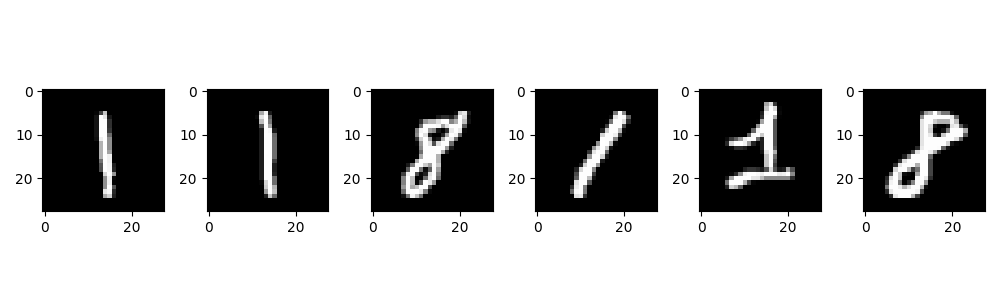

In [5]:
fig, axs = plt.subplots(1, 6, figsize=(10,3), tight_layout=True)
for i, ax in enumerate(axs):
    ax.imshow(X[i+2],cmap='gray', vmin=0, vmax=255)

## Threshold and sample

100%|█████████████████████████████████████████████████████████████████████████| 14702/14702 [00:00<00:00, 23965.46it/s]


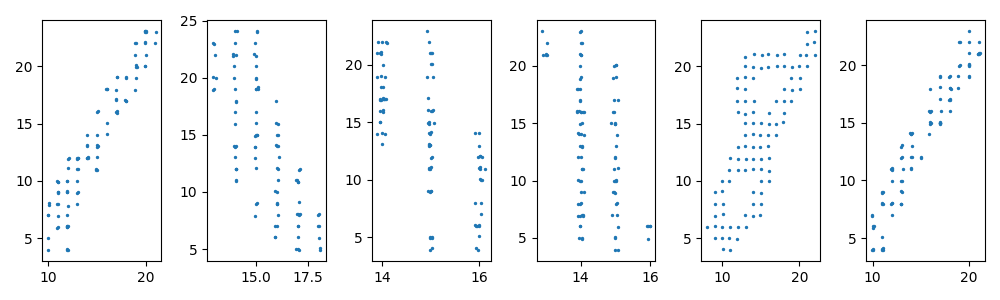

In [6]:
threshold = 150
sample_size = 100
noise = 0.05

np.random.seed(0)

Xhi = (X > threshold)

Xcloud = np.zeros((X.shape[0], sample_size, 2))

for idx in trange(X.shape[0]):
    sp = np.linspace(1.0, 28.0, 28)
    
    Hsp, Vsp = np.meshgrid(sp, sp[::-1])
    
    Hpts = Hsp[Xhi[idx,:,:]]
    Vpts = Vsp[Xhi[idx,:,:]]
    
    pts = (np.vstack((Hpts, Vpts))).T
    
    replace = (pts.shape[0] < sample_size)
    sample_idxs = np.random.choice(range(pts.shape[0]), size=sample_size, replace=replace)
    
    pts = pts[sample_idxs, :] + noise * np.random.randn(sample_size, 2)
    
    Xcloud[idx, :, :] = pts

fig, axs = plt.subplots(1, 6, figsize=(10,3), tight_layout=True)
for i, ax in enumerate(axs):
    ax.scatter(Xcloud[i,:,0], Xcloud[i,:,1], s=2.0)

# Compute invariants (stable rank)

interactive(children=(IntSlider(value=1, description='idx', max=10), Output()), _dom_classes=('widget-interact…

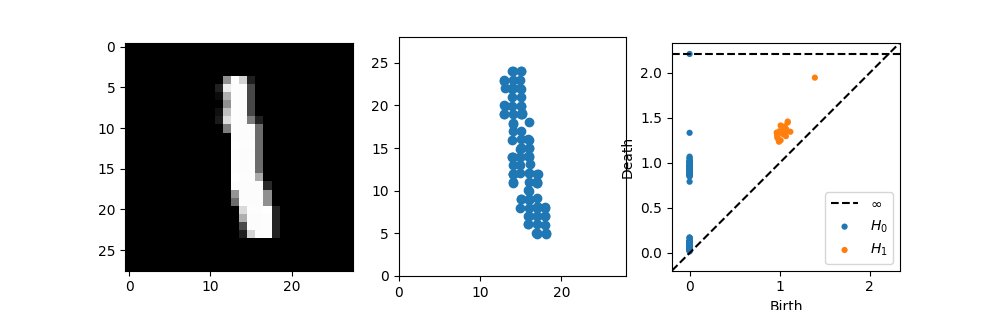

In [7]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
from persim import plot_diagrams
from ripser import Rips

def plotInteractive():
    fig, axs = plt.subplots(1, 3, figsize=(10,3.1), width_ratios=[1,1,1])
    
    def update(idx=1):
        rips = Rips(verbose=False)
        diagrams = rips.fit_transform(Xcloud[idx, :, :])
    
        axs[0].cla()
        axs[1].cla()
        axs[2].cla()
        
        axs[0].imshow(X[idx,:,:], cmap='gray', vmin=0, vmax=255)
        axs[1].scatter(Xcloud[idx, :, 0], Xcloud[idx, :, 1])
        axs[1].set_xlim([0, 28])
        axs[1].set_ylim([0, 28])
        plot_diagrams(diagrams, ax=axs[2])
        
    
        fig.canvas.draw()
    
    interact(update, idx=(0,10,1))

plotInteractive()

## Stable rank

We are computing a special case of the stable rank invariant. For more, see:

[2] Chachólski, W., & Riihimäki, H. (2020). Metrics and stabilization in one parameter persistence. *SIAM J. Appl. Algebra Geom.*, 4(1), 69-98.<br />
[3] Gäfvert, O., & Chachólski, W. (2017). Stable invariants for multiparameter persistence. *arXiv:1703.03632*.<br />
[4] Scolamiero, M., Chachólski, W., Lundman, A., Ramanujam, R., & Öberg, S. (2017). Multidimensional persistence and noise. *Found. Comput. Math.*, 17, 1367-1406.

~

In short, let $K(b,d)$ denote an interval module (bar) starting at $b \in [0, \infty)$ and ending at $d$.

If $\bigoplus_{i=1}^n K(b_i,d_i)$ is a barcode, then $\widehat{\mathrm{srank}}(\bigoplus_{i=1}^n K(b_i,d_i)) \colon [0, \infty) \to \mathbb{R}$ can be explicitly computed as $t \mapsto |\{i : d_i - b_i > t \}|$.

(Note that stable rank exists in more general settings.)

In [8]:
def compute_stable_rank(diagram):
    lifetimes = diagram[:,1] - diagram[:,0]
    lifetimes = np.sort(lifetimes)
    nodes, counts = np.unique(lifetimes, return_counts=True)

    sums = np.cumsum(counts[::-1])[::-1]
    
    times = np.insert(nodes, 0, 0)
    values = np.append(sums, 0)
    
    if times[-1] == np.inf:
        times = times[:-1]
        values = values[:-1]
    
    return np.vstack((times, values)).T

In [9]:
rips = Rips(verbose=False)
idx = 1
diagrams = rips.fit_transform(Xcloud[idx, :, :])
h1 = compute_stable_rank(diagrams[1])
print(h1)

[[ 0.         23.        ]
 [ 0.22718811 22.        ]
 [ 0.22784448 21.        ]
 [ 0.23986614 20.        ]
 [ 0.24283421 19.        ]
 [ 0.27310181 18.        ]
 [ 0.28199542 17.        ]
 [ 0.28832221 16.        ]
 [ 0.29036283 15.        ]
 [ 0.29466891 14.        ]
 [ 0.30546284 13.        ]
 [ 0.30891371 12.        ]
 [ 0.32150459 11.        ]
 [ 0.3248378  10.        ]
 [ 0.33242011  9.        ]
 [ 0.33552694  8.        ]
 [ 0.34005415  7.        ]
 [ 0.3513993   6.        ]
 [ 0.35366344  5.        ]
 [ 0.35925007  4.        ]
 [ 0.36968929  3.        ]
 [ 0.36982512  2.        ]
 [ 0.40468955  1.        ]
 [ 0.55580544  0.        ]]


In [10]:
import masspcf as mpcf

h1sr = mpcf.Pcf(h1)

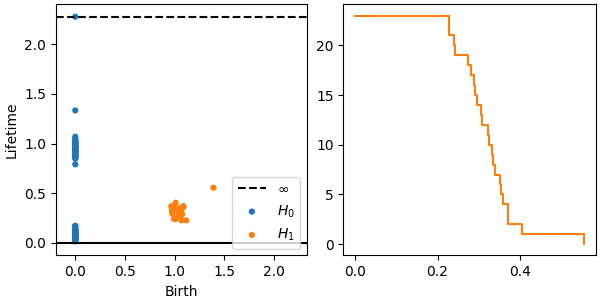

In [11]:
from masspcf.plotting import plot as pcfplot

fig, axs = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)

plot_diagrams(diagrams, ax=axs[0], lifetime=True)
pcfplot(h1sr, ax=axs[1], color='tab:orange')

## PCF arrays

In [12]:
Z = mpcf.zeros((10, 3, 5))
print(Z.shape)

Shape(10, 3, 5)


In [13]:
Xsmall = Xcloud[0:5000, :, :]
pcfs = mpcf.zeros((Xsmall.shape[0], 2)) # col 0 = H0, col 1 = H1

for idx, pts in enumerate(tqdm(Xsmall)):
    diagrams = rips.fit_transform(pts)
    
    srdata_h0 = compute_stable_rank(diagrams[0])
    srdata_h1 = compute_stable_rank(diagrams[1])
    
    pcfs[idx, 0] = mpcf.Pcf(srdata_h0)
    pcfs[idx, 1] = mpcf.Pcf(srdata_h1)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 549.39it/s]


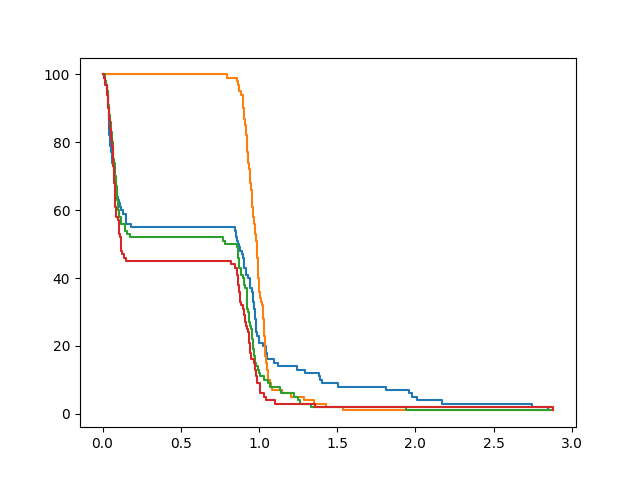

In [14]:
fig, ax = plt.subplots()
pcfplot(pcfs[10:14,0])

## Combining features

In [15]:
avgs = mpcf.mean(pcfs, dim=1)
print(avgs.shape)

Shape(5000)


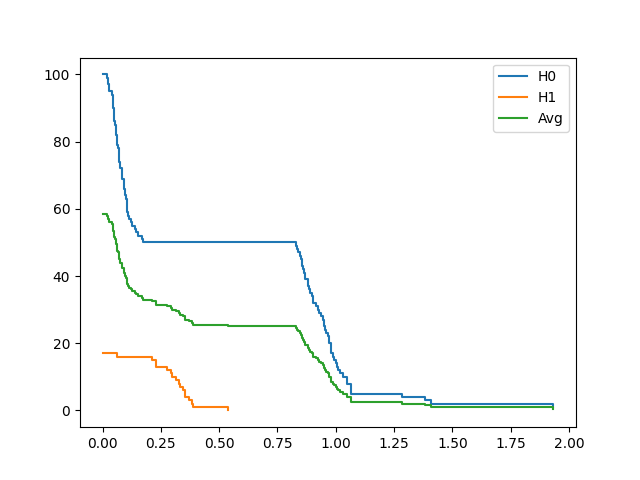

In [16]:
avfig, avax = plt.subplots()

pcfplot(pcfs[0,0], ax=avax, label='H0')
pcfplot(pcfs[0,1], ax=avax, label='H1')
pcfplot(avgs[0], ax=avax, label='Avg')

plt.legend()

# Clustering

## Compute distance matrix

In [17]:
D = mpcf.pdist(avgs)
print(D)
print(D.shape)

[[ 0.         4.0011654  9.072399  ... 27.778965   9.305885   4.64795  ]
 [ 4.0011654  0.        11.520903  ... 25.717815  11.917289   1.708406 ]
 [ 9.072399  11.520903   0.        ... 36.85134    1.0296581 12.579623 ]
 ...
 [27.778965  25.717815  36.85134   ...  0.        37.084835  24.385948 ]
 [ 9.305885  11.917289   1.0296581 ... 37.084835   0.        13.178361 ]
 [ 4.64795    1.708406  12.579623  ... 24.385948  13.178361   0.       ]]
(5000, 5000)


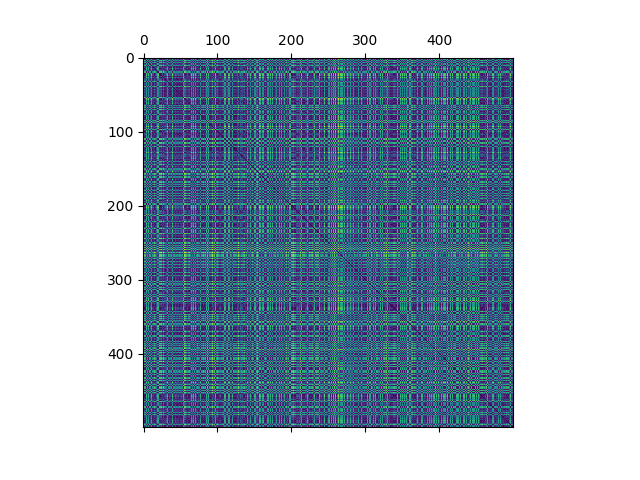

In [18]:
fig, ax = plt.subplots()
ax.matshow(D[0:500, 0:500])

## t-SNE visualization

We will visualize our 784-dimensional data using t-SNE [5] using distances from persistent homology (computed above).

[5] Van der Maaten, L., & Hinton, G. (2008). Visualizing data using t-SNE. *Journal of machine learning research*, 9(11).

In [19]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=3, metric='precomputed', init='random').fit_transform(D)

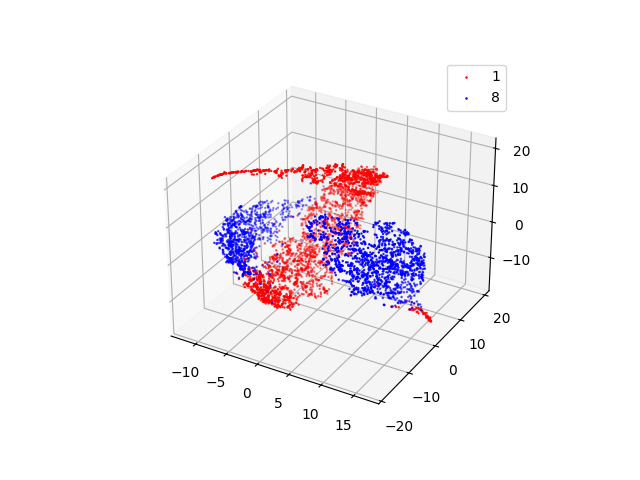

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

X_embedded_grouped = [ (i, X_embedded[y[:Xsmall.shape[0]] == str(i)]) for i in use_digits ]
colors = {use_digits[0]: 'red', use_digits[1]: 'blue'}

for i, grp in X_embedded_grouped:
    ax.scatter(grp[:,0], grp[:,1], grp[:,2], c=colors[i], label=str(i), s=0.6)

ax.legend()